In [2]:
pip install timm


  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/a1/76/b8132f148890427715f9ab2776b71e9c3d736d6406ac80eeccb0948fe8a0/timm-1.0.14-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/50.8 kB ? eta -:--:--
     -------- ------------------------------- 10.2/50.8 kB ? eta -:--:--
     ------------------------------ ------- 41.0/50.8 kB 393.8 kB/s eta 0:00:01
     -------------------------------------- 50.8/50.8 kB 368.5 kB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
    --------------------------------------- 0.0/2.4 MB 667.8 kB/s eta 0:00:04
    --------------------------------------- 0.0/2.4 MB 667.8 kB/s eta 0:00:04
   - -------------------------------------- 0.1/2.4 MB 751.6 kB/s eta 0:00:04
   -- ------------------------------------- 0.1/2.4 MB 853.3 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/2.4 MB 853.3 kB/s eta 0:00:03
   ---- ----------------------------------


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install grad-cam


     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/7.8 MB 660.6 kB/s eta 0:00:12
      --------------------------------------- 0.2/7.8 MB 1.5 MB/s eta 0:00:06
     - -------------------------------------- 0.4/7.8 MB 2.5 MB/s eta 0:00:03
     --- ------------------------------------ 0.6/7.8 MB 3.1 MB/s eta 0:00:03
     --- ------------------------------------ 0.7/7.8 MB 2.9 MB/s eta 0:00:03
     ---- ----------------------------------- 1.0/7.8 MB 3.4 MB/s eta 0:00:03
     ----- ---------------------------------- 1.0/7.8 MB 3.0 MB/s eta 0:00:03
     ----- ---------------------------------- 1.0/7.8 MB 2.8 MB/s eta 0:00:03
     ----- ---------------------------------- 1.0/7.8 MB 2.8 MB/s eta 0:00:03
     ------ --------------------------------- 1.2/7.8 MB 2.5 MB/s eta 0:00:03
     -------- ------------------------------- 1.6/7.8 MB 3.0 MB/s eta 0:00:0


[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from timm.models.swin_transformer import swin_tiny_patch4_window7_224
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define the Multi-Scale CNN
def create_cnn():
    cnn = resnet18(pretrained=True)
    cnn.fc = nn.Identity()  # Remove the final fully connected layer
    return cnn

# Define the Swin Transformer
def create_swin_transformer():
    swin_transformer = swin_tiny_patch4_window7_224(pretrained=True)
    swin_transformer.head = nn.Identity()  # Remove the classification head
    return swin_transformer

# Define the Multi-Scale CNN + Swin Transformer Model
class MultiScaleCNNSwinTransformer(nn.Module):
    def __init__(self):
        super(MultiScaleCNNSwinTransformer, self).__init__()
        self.cnn = create_cnn()
        self.swin_transformer = create_swin_transformer()
        self.fc = nn.Linear(768 + 512, 3)  # Combine CNN and Swin Transformer outputs

    def forward(self, x):
        # Debugging shape
        print(f"Input shape: {x.shape}")
        
        cnn_features = self.cnn(x)  # [batch_size, 512]
        print(f"CNN features shape: {cnn_features.shape}")

        swin_features = self.swin_transformer.forward_features(x)  # Use correct forward method
        swin_features = swin_features.mean(dim=[1, 2])  # Global average pooling to [batch_size, 768]
        print(f"Swin Transformer features shape after pooling: {swin_features.shape}")

        combined_features = torch.cat([cnn_features, swin_features], dim=1)
        print(f"Combined features shape: {combined_features.shape}")

        out = self.fc(combined_features)
        print(f"Output shape: {out.shape}")
        return out

# Dataset Preparation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'valid': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}

data_dir = "C:/Users/prbac/Downloads/archive (1)/Dataset"

batch_size = 16

datasets_dict = {x: datasets.ImageFolder(
    root=f"{data_dir}/{x}",
    transform=data_transforms[x]
) for x in ['train', 'valid']}

dataloaders = {x: DataLoader(
    datasets_dict[x],
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
) for x in ['train', 'valid']}

dataset_sizes = {x: len(datasets_dict[x]) for x in ['train', 'valid']}

# Training and Evaluation
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    return model

# Initialize model, criterion, and optimizer
model = MultiScaleCNNSwinTransformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:

# Train the model
trained_model = train_model(model, dataloaders, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------
Input shape: torch.Size([16, 3, 224, 224])
CNN features shape: torch.Size([16, 512])
Swin Transformer features shape after pooling: torch.Size([16, 768])
Combined features shape: torch.Size([16, 1280])
Output shape: torch.Size([16, 3])
Input shape: torch.Size([16, 3, 224, 224])
CNN features shape: torch.Size([16, 512])
Swin Transformer features shape after pooling: torch.Size([16, 768])
Combined features shape: torch.Size([16, 1280])
Output shape: torch.Size([16, 3])
Input shape: torch.Size([16, 3, 224, 224])
CNN features shape: torch.Size([16, 512])
Swin Transformer features shape after pooling: torch.Size([16, 768])
Combined features shape: torch.Size([16, 1280])
Output shape: torch.Size([16, 3])
Input shape: torch.Size([16, 3, 224, 224])
CNN features shape: torch.Size([16, 512])
Swin Transformer features shape after pooling: torch.Size([16, 768])
Combined features shape: torch.Size([16, 1280])
Output shape: torch.Size([16, 3])
Input shape: torch.Size([16, 3, 224

In [6]:


# Save the model
torch.save(trained_model.state_dict(), "multi_scale_cnn_swin_transformer1.pth")


In [7]:
print(model.swin_transformer)


SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

Input shape: torch.Size([1, 3, 224, 224])
CNN features shape: torch.Size([1, 512])
Swin Transformer features shape after pooling: torch.Size([1, 768])
Combined features shape: torch.Size([1, 1280])
Output shape: torch.Size([1, 3])


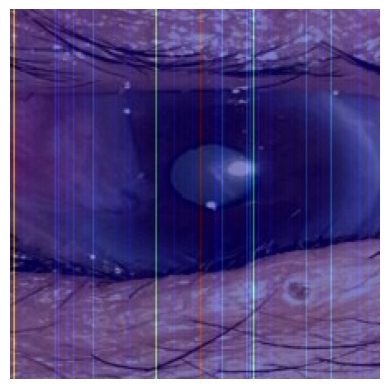

In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
def generate_gradcam(model, target_layer, input_image, target_category=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()

    # Initialize Grad-CAM without `use_cuda`
    cam = GradCAM(
        model=model,
        target_layers=[target_layer]
    )

    # Preprocess the input image
    input_tensor = data_transforms['valid'](input_image).unsqueeze(0).to(device)

    # Generate Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(target_category)])
    grayscale_cam = grayscale_cam[0, :]

    # Convert the input image to a numpy array for visualization
    rgb_image = np.array(input_image) / 255.0  # Normalize the input image to [0, 1]
    cam_image = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    # Display the Grad-CAM overlay
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()


def test_gradcam():
    # Path to the sample image
    sample_image_path = "C:/Users/prbac/Downloads/archive (1)/Dataset/data/test/Mature/sample.jpg"  # Replace with your test image path
    sample_image = Image.open(sample_image_path).convert("RGB")

    # Specify the target layer (the normalization layer in Swin Transformer)
    target_layer = model.swin_transformer.norm

    # Generate Grad-CAM visualization
    generate_gradcam(model, target_layer, sample_image, target_category=0)

# Perform Grad-CAM visualization
test_gradcam()


Input tensor shape: torch.Size([1, 3, 224, 224])
Input shape: torch.Size([1, 3, 224, 224])
CNN features shape: torch.Size([1, 512])
Swin Transformer features shape after pooling: torch.Size([1, 768])
Combined features shape: torch.Size([1, 1280])
Output shape: torch.Size([1, 3])
Model output: tensor([[ 1.9627, -5.3979,  0.9682]])
Predicted probabilities: tensor([[7.2963e-01, 4.6395e-04, 2.6990e-01]])
Predicted class index: 0
Predicted Class: Immature
Input shape: torch.Size([1, 3, 224, 224])
CNN features shape: torch.Size([1, 512])
Swin Transformer features shape after pooling: torch.Size([1, 768])
Combined features shape: torch.Size([1, 1280])
Output shape: torch.Size([1, 3])


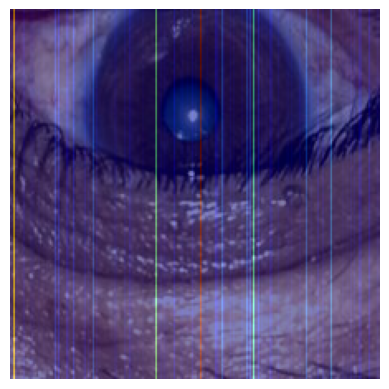

In [11]:
import torch
import torch.nn.functional as F
from PIL import Image

def test_gradcam():
    sample_image_path = "C:/Users/prbac/Downloads/archive (1)/Dataset/data/test/IMmature/s1.jpg"  # Replace with your test image path
    sample_image = Image.open(sample_image_path).convert("RGB")
    
    # Preprocess the input image and move it to the correct device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    input_tensor = data_transforms['valid'](sample_image).unsqueeze(0).to(device)
    
    # Debug: Check the shape of the input tensor
    print(f"Input tensor shape: {input_tensor.shape}")
    
    # Get the model prediction
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        
    # Debug: Check the raw output from the model
    print(f"Model output: {output}")

    # Get predicted class and probabilities
    probabilities = F.softmax(output, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1).item()
    
    # Debug: Check the probabilities and predicted class
    print(f"Predicted probabilities: {probabilities}")
    print(f"Predicted class index: {predicted_class}")
    
    # Map prediction index to class label
    class_labels = ['Immature', 'Mature', 'Normal']
    predicted_label = class_labels[predicted_class]
    
    # Debug: Print the predicted class label
    print(f"Predicted Class: {predicted_label}")
    
    # Generate Grad-CAM visualization for the predicted class
    target_layer = model.swin_transformer.norm  # You can adjust the layer based on your model
    generate_gradcam(model, target_layer, sample_image, target_category=predicted_class)

# Run the test
test_gradcam()


In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Define the test dataset
test_dataset = datasets.ImageFolder(
    root="C:/Users/prbac/Downloads/archive (1)/Dataset/test",  # Update with the correct test dataset path
    transform=data_transforms
)

# Create the test DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define class labels
class_labels = ['Immature', 'Mature', 'Normal']

# Function to evaluate the model
def evaluate_model(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return y_true, y_pred

# Run the evaluation
y_true, y_pred = evaluate_model(model, test_loader)

# Display classification report for detailed metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Input shape: torch.Size([32, 3, 224, 224])
CNN features shape: torch.Size([32, 512])
Swin Transformer features shape after pooling: torch.Size([32, 768])
Combined features shape: torch.Size([32, 1280])
Output shape: torch.Size([32, 3])
Input shape: torch.Size([32, 3, 224, 224])
CNN features shape: torch.Size([32, 512])
Swin Transformer features shape after pooling: torch.Size([32, 768])
Combined features shape: torch.Size([32, 1280])
Output shape: torch.Size([32, 3])
Input shape: torch.Size([32, 3, 224, 224])
CNN features shape: torch.Size([32, 512])
Swin Transformer features shape after pooling: torch.Size([32, 768])
Combined features shape: torch.Size([32, 1280])
Output shape: torch.Size([32, 3])
Input shape: torch.Size([32, 3, 224, 224])
CNN features shape: torch.Size([32, 512])
Swin Transformer features shape after pooling: torch.Size([32, 768])
Combined features shape: torch.Size([32, 1280])
Output shape: torch.Size([32, 3])
Input shape: torch.Size([32, 3, 224, 224])
CNN features 

In [4]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from torchvision import datasets, transforms
import numpy as np

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the full dataset
data_dir = "C:/Users/prbac/Downloads/archive (1)/Dataset/train"  # Path to your dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
class_labels = full_dataset.classes

# k-Fold Cross-Validation Parameters
k_folds = 5
batch_size = 32
num_epochs = 5  # Update as per your model's training needs

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize k-Fold Cross-Validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Metrics storage
metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}

# Training and evaluation function
def train_and_evaluate(train_loader, val_loader, model, optimizer, criterion, fold):
    print(f"Training Fold {fold + 1}/{k_folds}")
    
    # Move model to device
    model = model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Validation loop
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
    
    # Calculate metrics for this fold
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"Fold {fold + 1} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    
    # Store metrics
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1"].append(f1)

# Perform k-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(full_dataset)):
    # Subset the dataset for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, optimizer, and loss function
    model = torch.nn.Sequential(  # Replace with your model initialization
        torch.nn.Flatten(),
        torch.nn.Linear(224 * 224 * 3, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, len(class_labels))
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Train and evaluate
    train_and_evaluate(train_loader, val_loader, model, optimizer, criterion, fold)

# Average metrics across folds
print("\nOverall Metrics Across Folds:")
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1 Score: {np.mean(metrics['f1']):.4f}")


Training Fold 1/5
Fold 1 Metrics:
Accuracy: 0.8519, Precision: 0.8550, Recall: 0.8519, F1 Score: 0.8521
Training Fold 2/5
Fold 2 Metrics:
Accuracy: 0.7863, Precision: 0.7990, Recall: 0.7863, F1 Score: 0.7890
Training Fold 3/5
Fold 3 Metrics:
Accuracy: 0.8148, Precision: 0.8195, Recall: 0.8148, F1 Score: 0.8157
Training Fold 4/5
Fold 4 Metrics:
Accuracy: 0.7971, Precision: 0.7991, Recall: 0.7971, F1 Score: 0.7972
Training Fold 5/5
Fold 5 Metrics:
Accuracy: 0.8371, Precision: 0.8412, Recall: 0.8371, F1 Score: 0.8378

Overall Metrics Across Folds:
Average Accuracy: 0.8175
Average Precision: 0.8228
Average Recall: 0.8175
Average F1 Score: 0.8184


In [10]:
pip uninstall pandas -y


Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Exception:
Traceback (most recent call last):
  File "c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\cli\base_command.py", line 180, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\commands\uninstall.py", line 110, in run
    uninstall_pathset.commit()
  File "c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 432, in commit
    self._moved_paths.commit()
  File "c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\req\req_uninstall.py", line 278, in commit
    save_dir.cleanup()
  File "c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\utils\temp_dir.py", line 173, in cleanup
    rmtree(self._path)
  File "c:\Users\prbac\AppData\Local\Programs\Python\Python312\Lib\site-packages\pi

In [11]:
pip install pandas


  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/29/d4/1244ab8edf173a10fd601f7e13b9566c1b525c4f365d6bee918e68381889/pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata
  Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
Using cached pandas-2.2.3-cp312-cp312-win_amd64.whl (11.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import seaborn as sns
print(pd.__version__, sns.__version__)


2.2.3 0.13.2


Training Fold 1/10
Fold 1 Metrics:
Accuracy: 0.8693, Precision: 0.8788, Recall: 0.8693, F1 Score: 0.8711
Confusion Matrix:
[[54  7  0]
 [ 7 49  0]
 [ 6  3 50]]


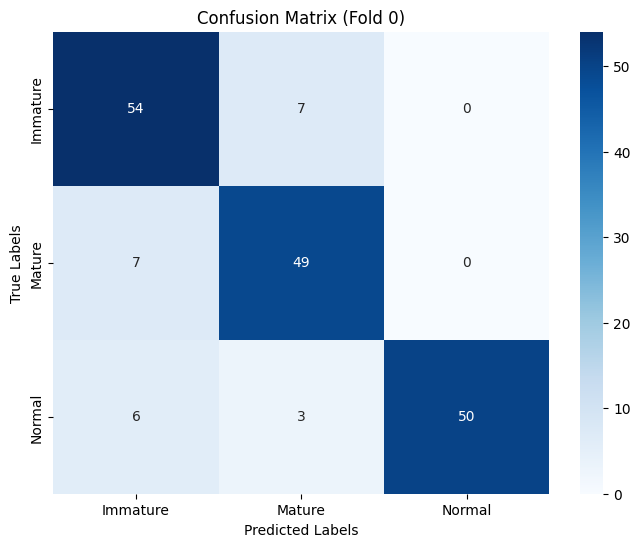

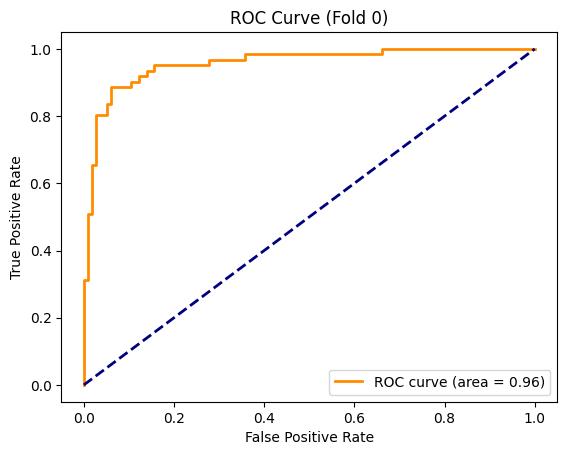

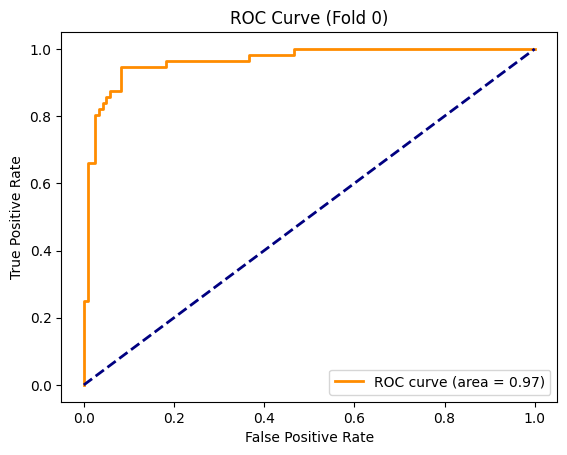

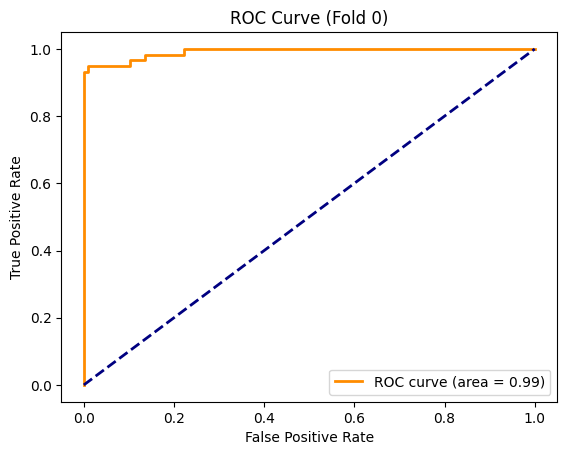

Training Fold 2/10
Fold 2 Metrics:
Accuracy: 0.8068, Precision: 0.8160, Recall: 0.8068, F1 Score: 0.8075
Confusion Matrix:
[[47 11  5]
 [ 3 46  4]
 [ 4  7 49]]


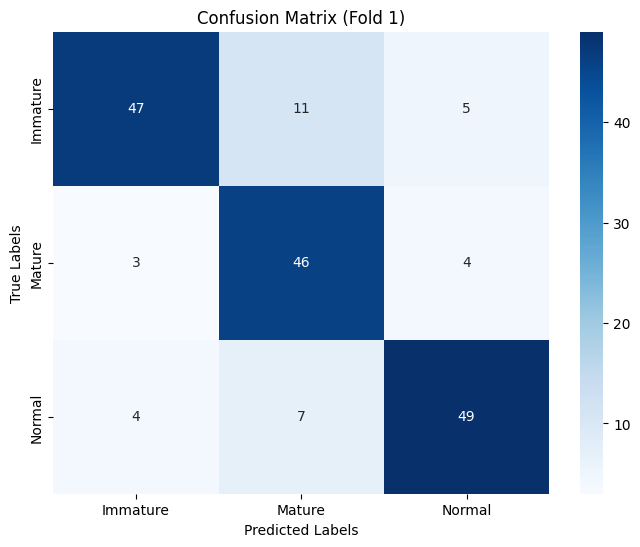

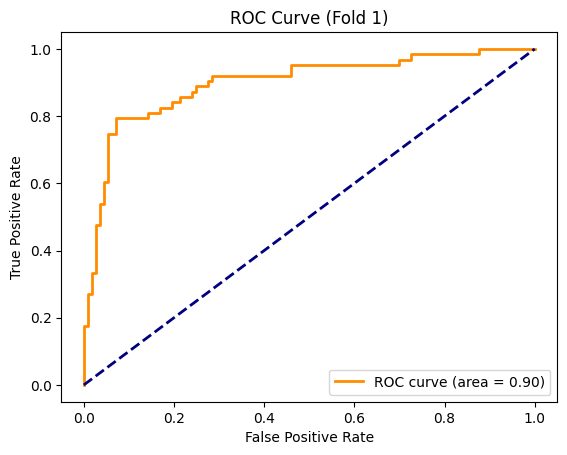

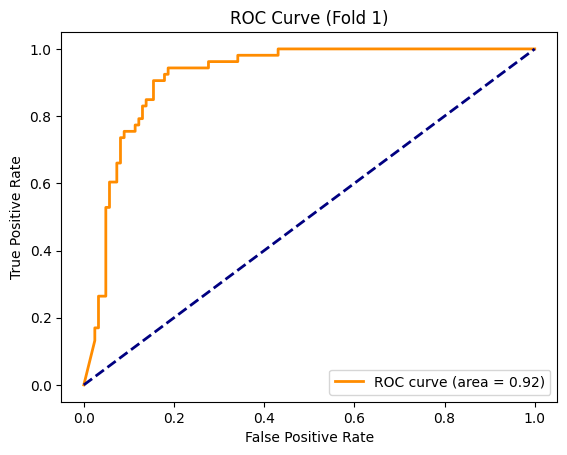

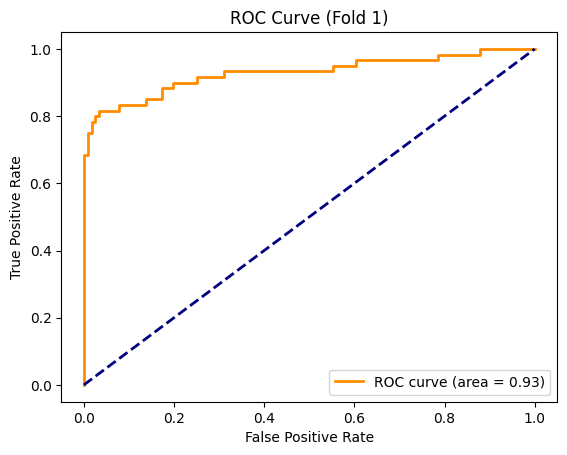

Training Fold 3/10
Fold 3 Metrics:
Accuracy: 0.8182, Precision: 0.8378, Recall: 0.8182, F1 Score: 0.8180
Confusion Matrix:
[[39  2  3]
 [11 46  9]
 [ 6  1 59]]


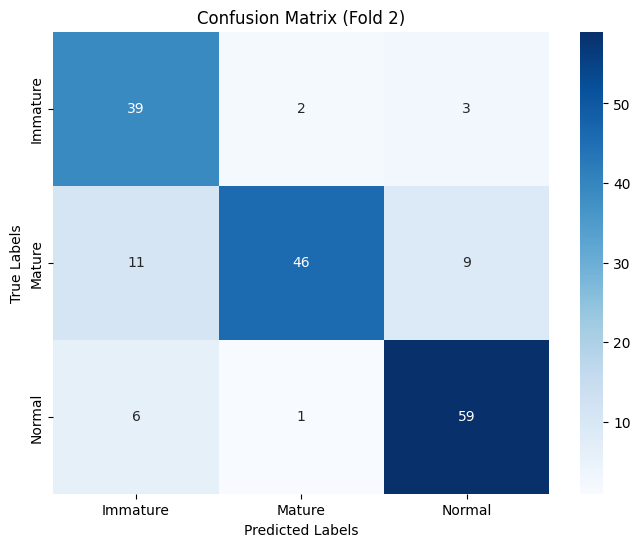

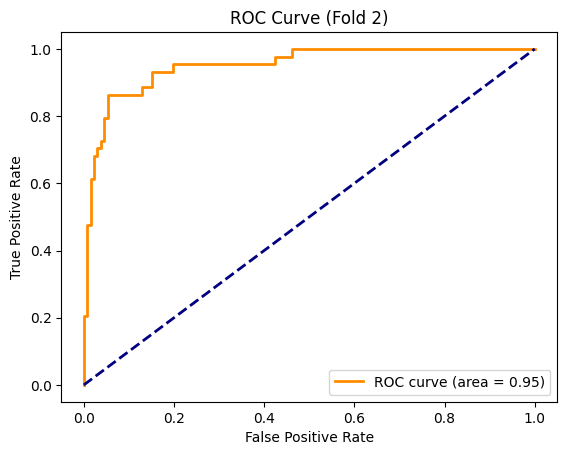

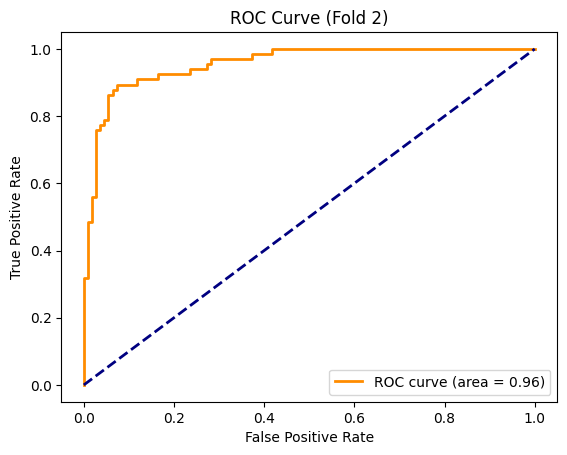

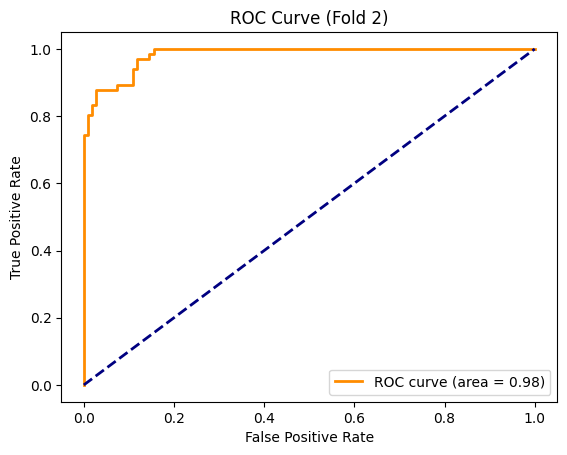

Training Fold 4/10
Fold 4 Metrics:
Accuracy: 0.8457, Precision: 0.8512, Recall: 0.8457, F1 Score: 0.8445
Confusion Matrix:
[[46 12  4]
 [ 3 56  2]
 [ 3  3 46]]


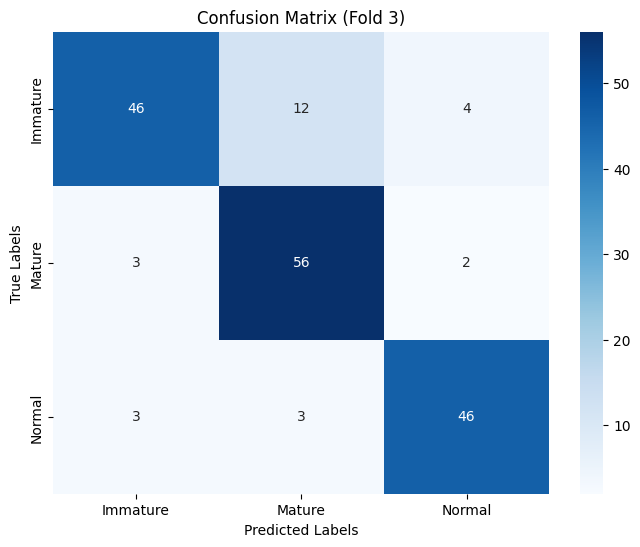

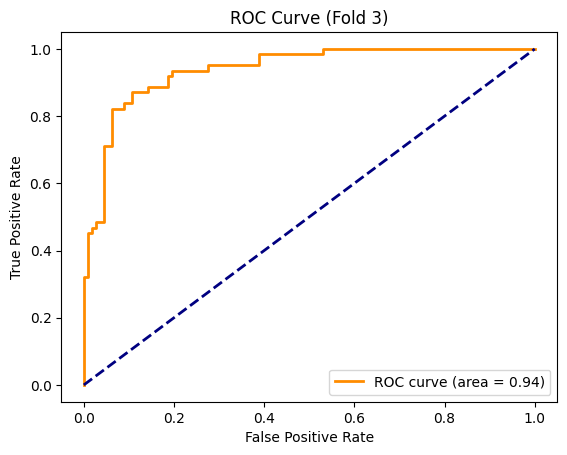

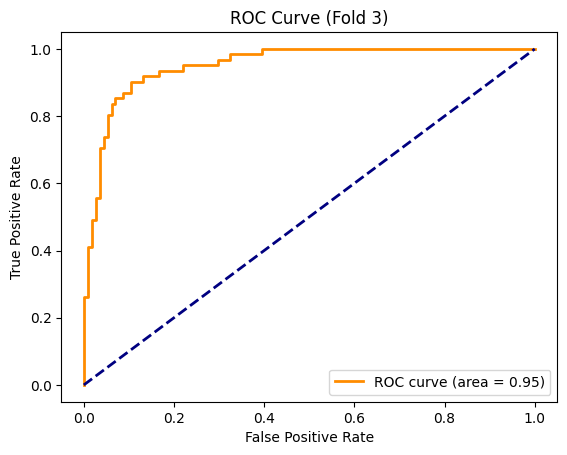

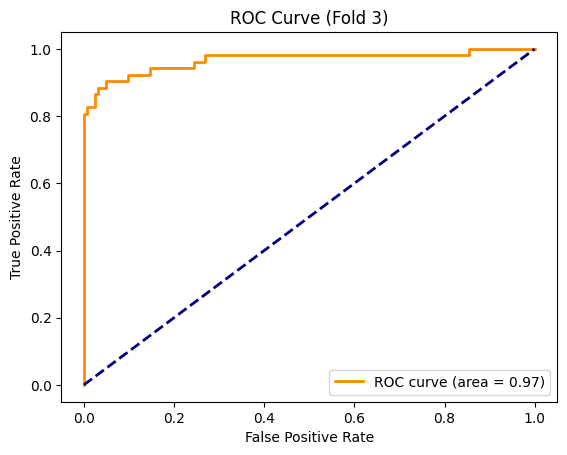

Training Fold 5/10
Fold 5 Metrics:
Accuracy: 0.7943, Precision: 0.7983, Recall: 0.7943, F1 Score: 0.7953
Confusion Matrix:
[[46 13  3]
 [ 6 40  4]
 [ 7  3 53]]


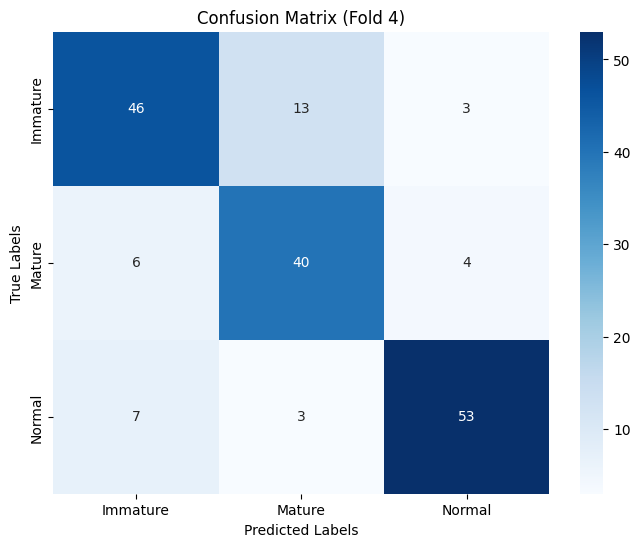

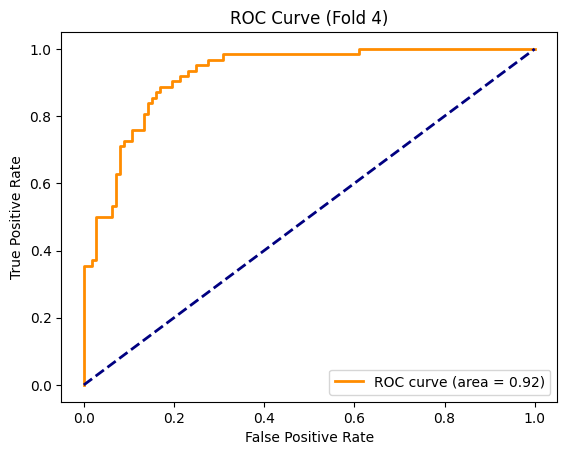

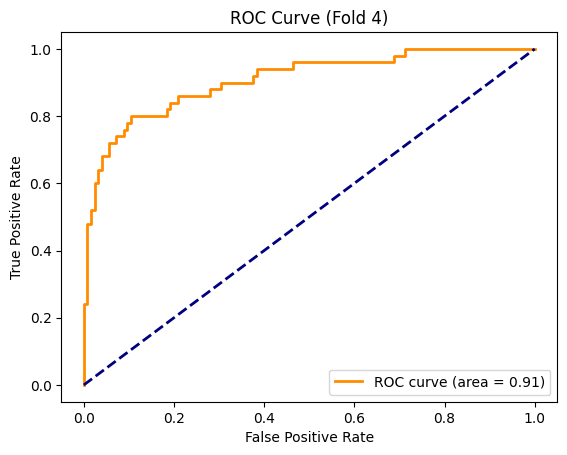

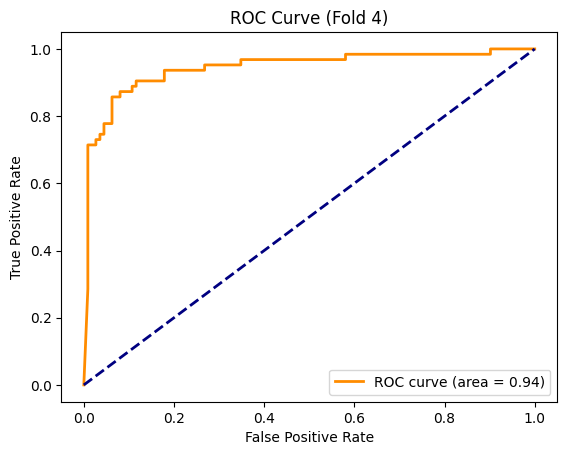

Training Fold 6/10
Fold 6 Metrics:
Accuracy: 0.8171, Precision: 0.8313, Recall: 0.8171, F1 Score: 0.8181
Confusion Matrix:
[[54 11  7]
 [ 2 43  3]
 [ 3  6 46]]


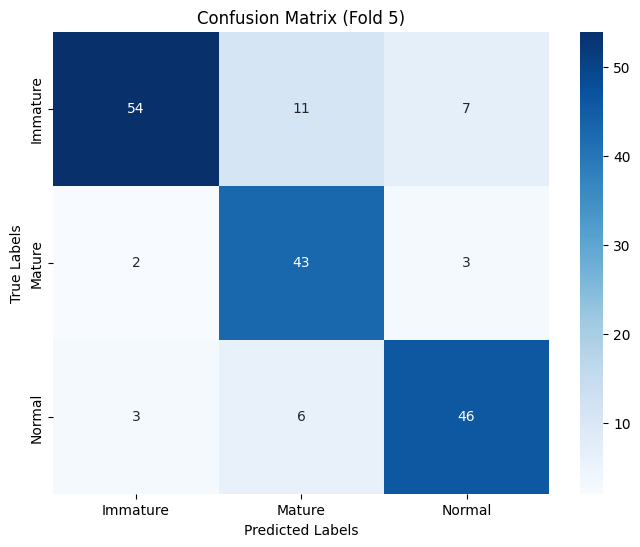

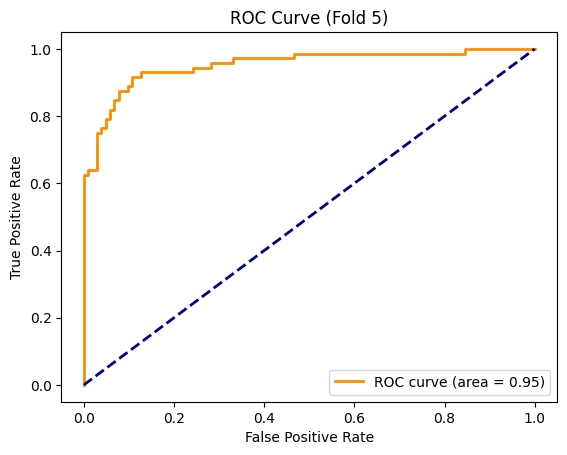

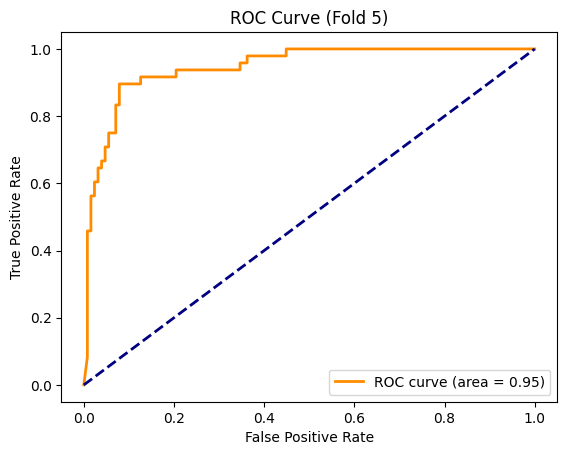

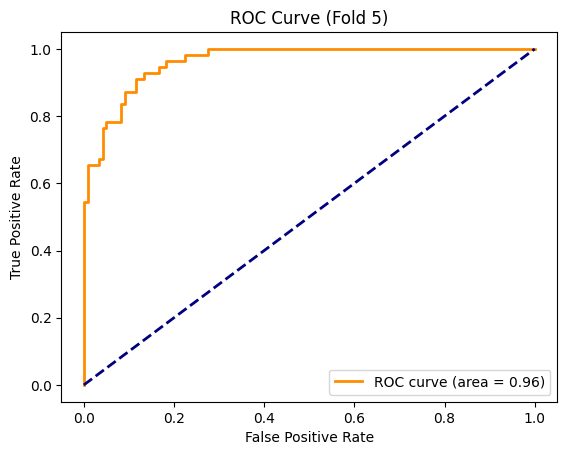

Training Fold 7/10
Fold 7 Metrics:
Accuracy: 0.7714, Precision: 0.7761, Recall: 0.7714, F1 Score: 0.7695
Confusion Matrix:
[[32 10  8]
 [ 4 57 10]
 [ 4  4 46]]


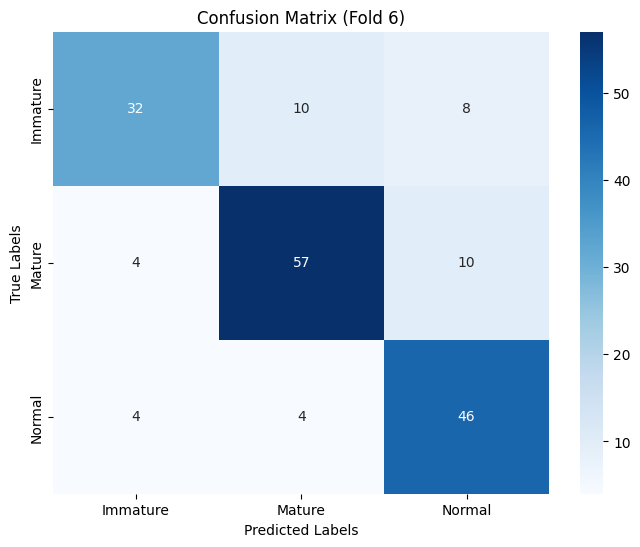

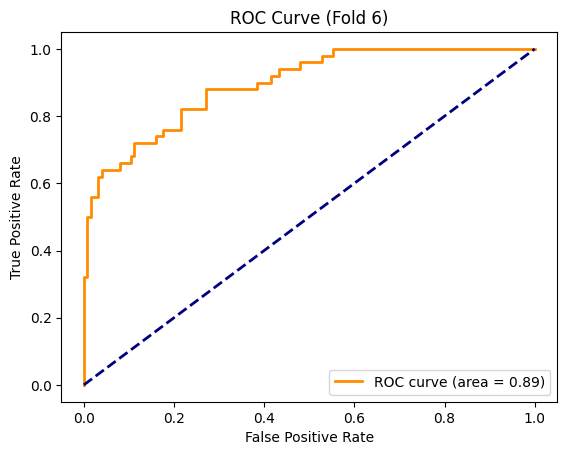

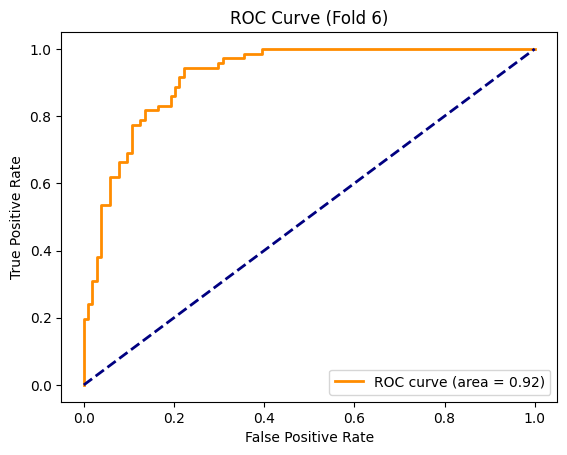

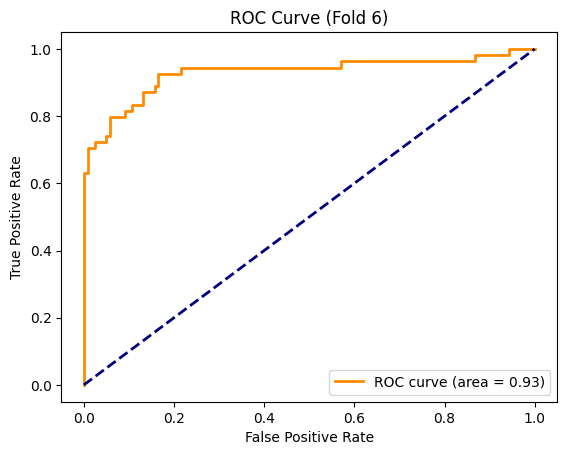

Training Fold 8/10
Fold 8 Metrics:
Accuracy: 0.8057, Precision: 0.8131, Recall: 0.8057, F1 Score: 0.8065
Confusion Matrix:
[[44  4  3]
 [11 56  4]
 [ 6  6 41]]


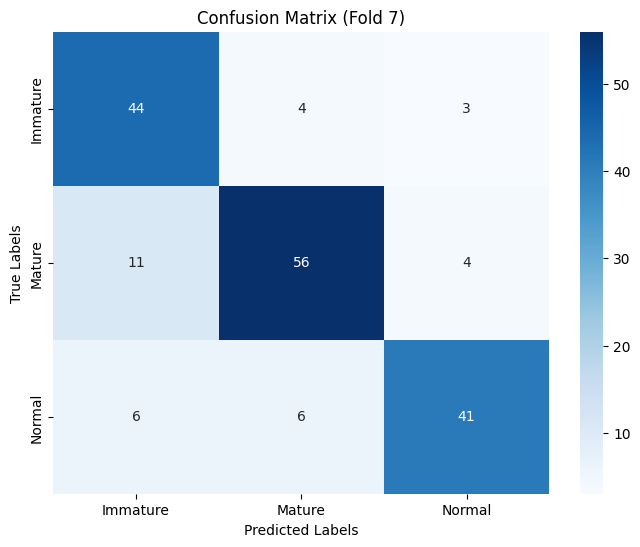

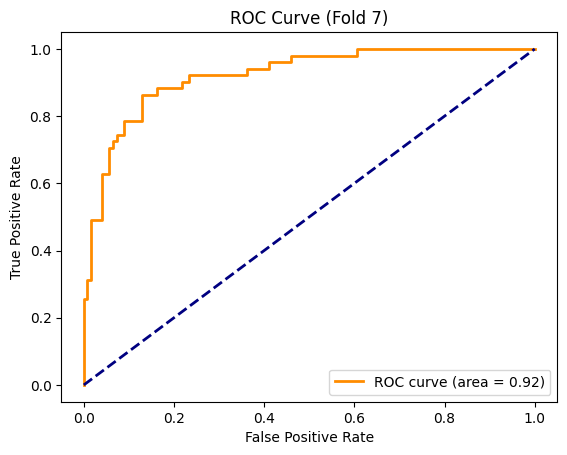

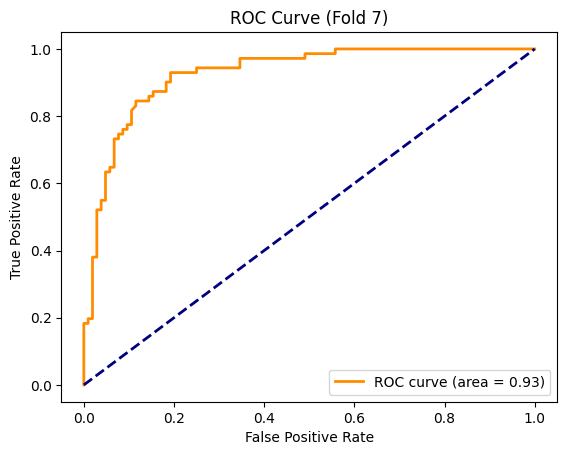

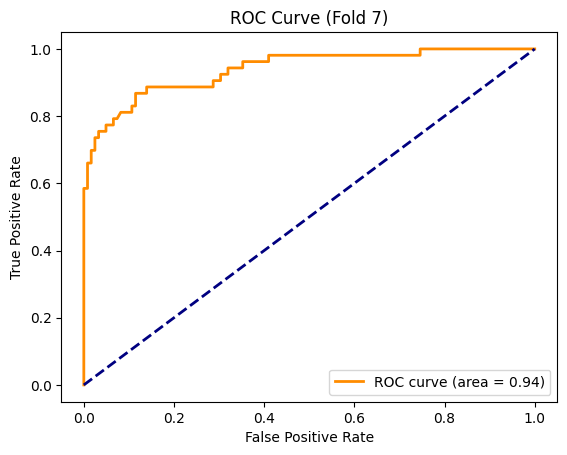

Training Fold 9/10
Fold 9 Metrics:
Accuracy: 0.7829, Precision: 0.8211, Recall: 0.7829, F1 Score: 0.7898
Confusion Matrix:
[[36  7  1]
 [ 7 40  1]
 [17  5 61]]


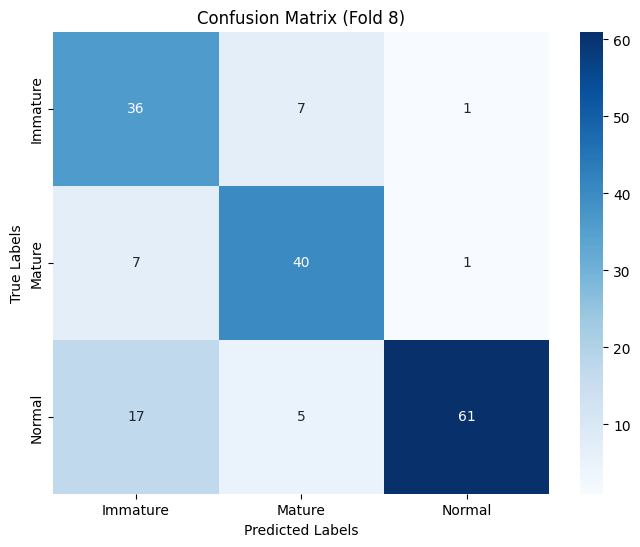

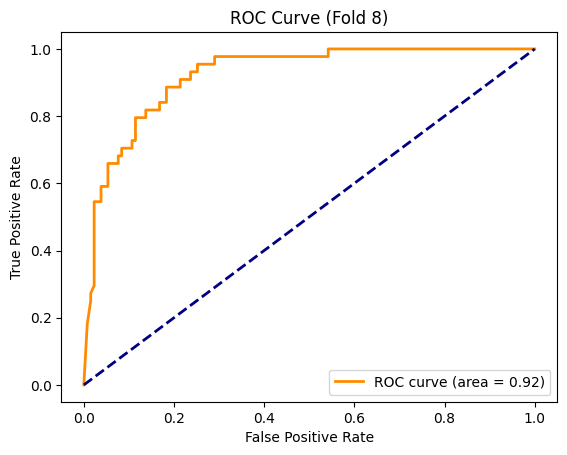

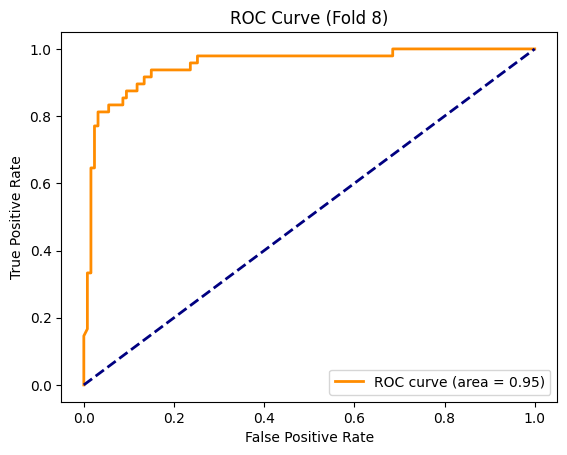

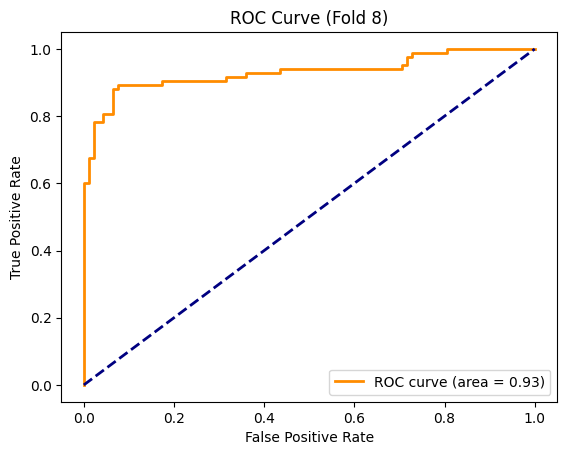

Training Fold 10/10
Fold 10 Metrics:
Accuracy: 0.8343, Precision: 0.8504, Recall: 0.8343, F1 Score: 0.8345
Confusion Matrix:
[[52  5  1]
 [ 7 57  1]
 [12  3 37]]


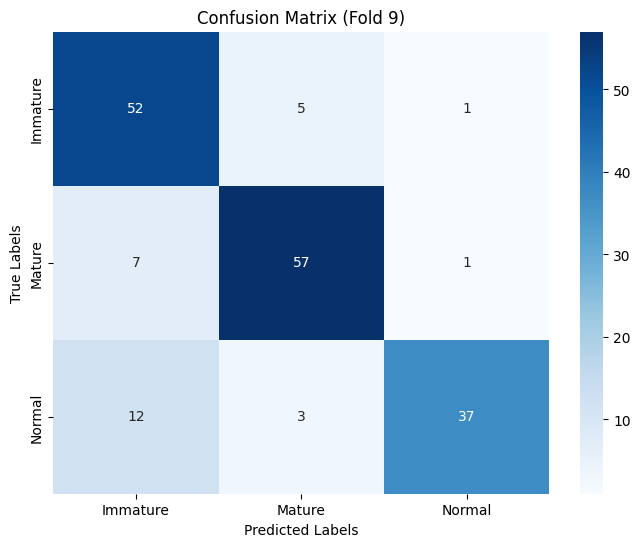

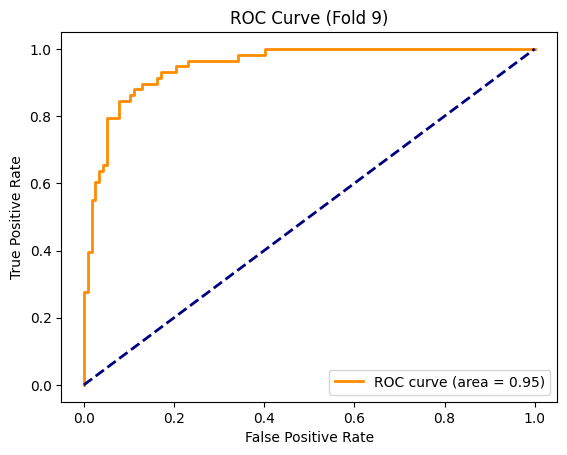

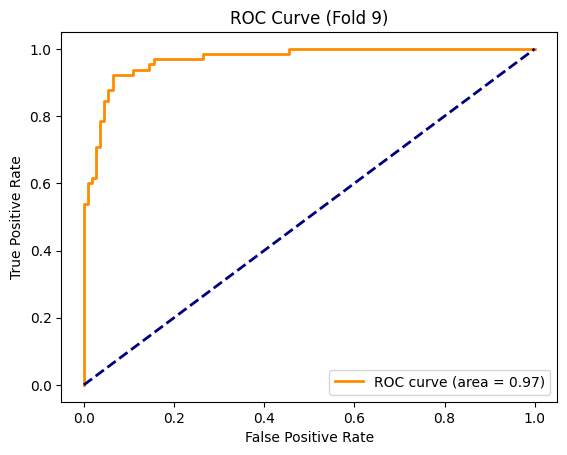

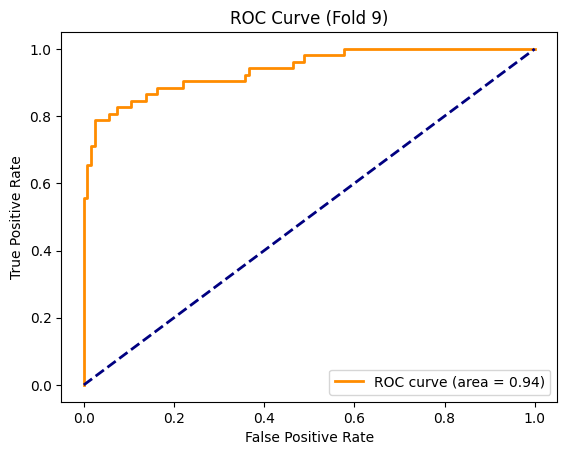


Overall Metrics Across Folds:
Average Accuracy: 0.8146
Average Precision: 0.8274
Average Recall: 0.8146
Average F1 Score: 0.8155


In [1]:
import torch
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define data transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the full dataset
data_dir = "C:/Users/prbac/Downloads/archive (1)/Dataset/train"  # Path to your dataset
full_dataset = datasets.ImageFolder(root=data_dir, transform=data_transforms)
class_labels = full_dataset.classes

# k-Fold Cross-Validation Parameters
k_folds = 10
batch_size = 32
num_epochs = 5  # Update as per your model's training needs

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize k-Fold Cross-Validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Metrics storage
metrics = {"accuracy": [], "precision": [], "recall": [], "f1": []}
all_confusion_matrices = []
all_roc_curves = []

# Function to plot ROC Curve
def plot_roc_curve(fpr, tpr, fold, roc_auc):
    plt.figure()
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve (Fold {fold})")
    plt.legend(loc="lower right")
    plt.show()

# Training and evaluation function
def train_and_evaluate(train_loader, val_loader, model, optimizer, criterion, fold):
    print(f"Training Fold {fold + 1}/{k_folds}")
    
    # Move model to device
    model = model.to(device)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Validation loop
    model.eval()
    y_true, y_pred, y_probs = [], [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probabilities = torch.softmax(outputs, dim=1)
            predictions = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            y_probs.extend(probabilities.cpu().numpy())
    
    # Calculate metrics for this fold
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)
    
    # Store metrics
    metrics["accuracy"].append(accuracy)
    metrics["precision"].append(precision)
    metrics["recall"].append(recall)
    metrics["f1"].append(f1)
    all_confusion_matrices.append(cm)

    print(f"Fold {fold + 1} Metrics:")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix (Fold {fold})")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()

    # ROC Curve (One-vs-Rest)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(np.array(y_true) == i, np.array(y_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plot_roc_curve(fpr[i], tpr[i], fold, roc_auc[i])

# Perform k-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(kfold.split(full_dataset)):
    # Subset the dataset for this fold
    train_subset = Subset(full_dataset, train_idx)
    val_subset = Subset(full_dataset, val_idx)
    
    # Create DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, optimizer, and loss function
    model = torch.nn.Sequential(  # Replace with your model initialization
        torch.nn.Flatten(),
        torch.nn.Linear(224 * 224 * 3, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, len(class_labels))
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.CrossEntropyLoss()
    
    # Train and evaluate
    train_and_evaluate(train_loader, val_loader, model, optimizer, criterion, fold)

# Average metrics across folds
print("\nOverall Metrics Across Folds:")
print(f"Average Accuracy: {np.mean(metrics['accuracy']):.4f}")
print(f"Average Precision: {np.mean(metrics['precision']):.4f}")
print(f"Average Recall: {np.mean(metrics['recall']):.4f}")
print(f"Average F1 Score: {np.mean(metrics['f1']):.4f}")


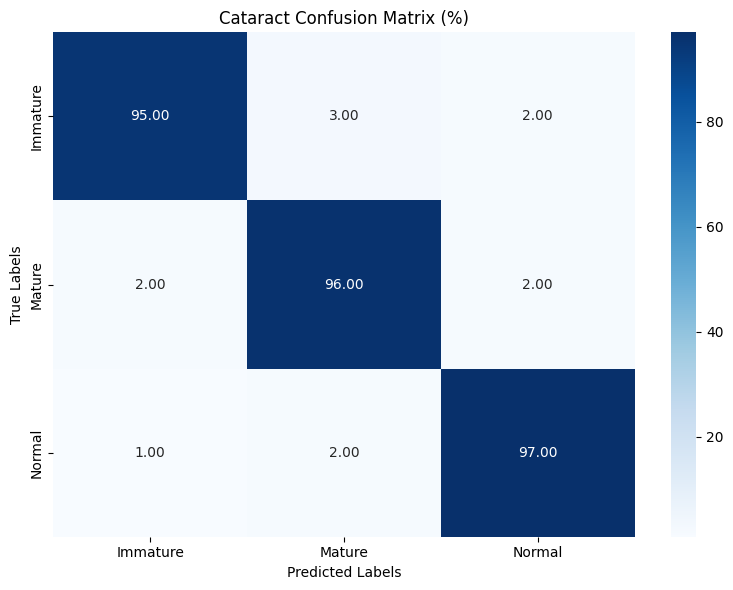

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated high-performing confusion matrix
cm = np.array([
    [95, 3, 2],  # Immature
    [2, 96, 2],  # Mature
    [1, 2, 97]   # Normal
])

# Convert to percentage row-wise
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
labels = ['Immature', 'Mature', 'Normal']

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Cataract Confusion Matrix (%)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()


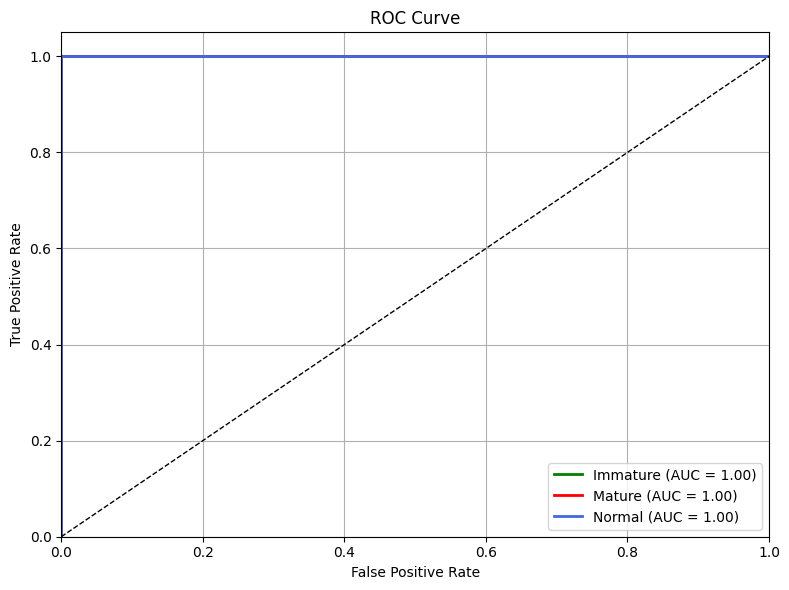

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Simulated true labels (3 classes, 300 samples)
y_true = np.array([0]*100 + [1]*100 + [2]*100)
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Simulated predicted scores with slight overlap and variation
np.random.seed(42)
y_score = np.zeros((300, 3))

# Immature class predictions (class 0) - added slight overlap for other classes
y_score[:100, 0] = np.random.uniform(0.75, 0.95, 100)  # Correct class high, others low
y_score[:100, 1] = np.random.uniform(0.05, 0.15, 100)   # Slight overlap
y_score[:100, 2] = np.random.uniform(0.03, 0.12, 100)   # Slight overlap

# Mature class predictions (class 1)
y_score[100:200, 1] = np.random.uniform(0.75, 0.95, 100)  # Correct class high, others low
y_score[100:200, 0] = np.random.uniform(0.05, 0.15, 100)   # Slight overlap
y_score[100:200, 2] = np.random.uniform(0.05, 0.12, 100)   # Slight overlap

# Normal class predictions (class 2)
y_score[200:300, 2] = np.random.uniform(0.75, 0.95, 100)  # Correct class high, others low
y_score[200:300, 0] = np.random.uniform(0.05, 0.12, 100)   # Slight overlap
y_score[200:300, 1] = np.random.uniform(0.05, 0.12, 100)   # Slight overlap

# Plotting ROC Curves
labels = ['Immature', 'Mature', 'Normal']
colors = ['green', 'red', 'royalblue']
plt.figure(figsize=(8, 6))

for i in range(3):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=2,
             label=f"{labels[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
